# **Comprehensive Guide to Tree-Based Algorithms**

## Decision Trees, Random Forests & XGBoost Explained

This notebook provides a detailed explanation of three fundamental tree-based machine learning algorithms:
1. **Decision Trees** - Single tree with recursive splitting
2. **Random Forests** - Ensemble of randomized trees
3. **XGBoost** - Gradient boosted trees with regularization

We'll use the **Heron WellNest dataset** for practical demonstrations and manual calculations.

---

## **Setup and Imports**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.set_printoptions(precision=4, suppress=True)

---
# **Part 1: Decision Trees** 🌳

## **Theory**

A **Decision Tree** is a supervised learning algorithm that recursively splits data based on feature values to create a tree structure for classification or regression.

### **Key Concepts:**
1. **Gini Impurity** - Measures the probability of misclassification if you randomly label a sample according to the label distribution in a node
2. **Gini Gain (Impurity Decrease)** - Reduction in Gini impurity after a split
3. **Recursive Splitting** - Build tree by selecting best features

### **Algorithm Flow:**
```
1. Calculate Gini impurity of entire dataset
2. For each feature:
   - Split data based on feature values (or thresholds for continuous)
   - Calculate weighted Gini impurity of subsets
   - Compute Gini Gain (impurity decrease)
3. Select feature (and threshold) with highest Gini Gain
4. Create node with selected feature
5. Recursively repeat for each branch until:
   - All samples in node belong to same class (pure node)
   - No more features to split on
   - Stopping criteria met (max_depth, min_samples)
```

## **Sample Dataset for Manual Calculations**

In [19]:
# Create the same sample dataset from your example
sample_data = pd.DataFrame({
    'p_anxiety': [0.139, 0.0, 0.0, 0.085, 0.048],
    'p_normal': [0.546, 0.0, 0.0, 0.439, 0.063],
    'gratitude_flag': [0, 0, 1, 1, 1],
    'Happy': [0, 1, 0, 0, 0],
    'Stressed': [0, 0, 0, 0, 1],
    'WellbeingClass': ['Thriving', 'Thriving', 'Excelling', 'Struggling', 'InCrisis']
})

print("📊 Sample Dataset:")
print("=" * 80)
display(sample_data)

print("\n📈 Class Distribution:")
class_counts = sample_data['WellbeingClass'].value_counts()
print(class_counts)
print(f"\nTotal instances: {len(sample_data)}")

📊 Sample Dataset:


,p_anxiety,p_normal,gratitude_flag,Happy,Stressed,WellbeingClass
0,0.139,0.546,0,0,0,Thriving
1,0.000,0.000,0,1,0,Thriving
2,0.000,0.000,1,0,0,Excelling
3,0.085,0.439,1,0,0,Struggling
4,0.048,0.063,1,0,1,InCrisis



📈 Class Distribution:
WellbeingClass
Thriving      2
Excelling     1
Struggling    1
InCrisis      1
Name: count, dtype: int64

Total instances: 5


## **Step 1: Gini Impurity Calculation**

### **Mathematical Formula:**

$$
\text{Gini}(S) = 1 - \sum_{i=1}^{c} p_i^2
$$

Where:
- $S$ = dataset
- $c$ = number of classes
- $p_i$ = probability of class $i$

### **Pseudocode:**
```
FUNCTION Gini(dataset):
    classes ← unique class labels in dataset
    gini ← 1

    FOR each class c in classes:
        p ← count(c) / total instances
        gini ← gini - p * p

    RETURN gini
```

In [20]:
def calculate_gini(data, target_col='WellbeingClass'):
    """
    Calculate Gini impurity of a dataset.

    Gini measures the probability of misclassification when labeling
    according to the label distribution in the node.
    - Gini = 0: Pure (all samples belong to one class)
    - Gini = max: Maximum impurity (samples evenly distributed)
    """
    total = len(data)
    if total == 0:
        return 0.0

    # Class probabilities
    probs = data[target_col].value_counts(normalize=True).values
    gini = 1.0 - np.sum(probs ** 2)

    # Verbose breakdown for transparency
    print(f"\n🔢 Calculating Gini for {total} samples:")
    print("=" * 60)
    for cls, p in data[target_col].value_counts(normalize=True).items():
        print(f"  Class '{cls}': p = {p:.4f}, p^2 = {p**2:.4f}")
    print(f"✅ Total Gini: {gini:.4f}")
    print("=" * 60)
    return gini

# Calculate Gini of the entire dataset
initial_gini = calculate_gini(sample_data)


🔢 Calculating Gini for 5 samples:
  Class 'Thriving': p = 0.4000, p^2 = 0.1600
  Class 'Excelling': p = 0.2000, p^2 = 0.0400
  Class 'Struggling': p = 0.2000, p^2 = 0.0400
  Class 'InCrisis': p = 0.2000, p^2 = 0.0400
✅ Total Gini: 0.7200


### **Interpretation:**

A higher Gini impurity indicates more mixed classes in a node. The goal of splitting is to choose features/thresholds that achieve the largest decrease in Gini impurity (i.e., produce purer child nodes).

## **Step 2: Gini Gain (Impurity Decrease) Calculation**

### **Mathematical Formula:**

$$
\text{GiniGain}(S, A) = \text{Gini}(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \cdot \text{Gini}(S_v)
$$

Where:
- $S$ = dataset
- $A$ = feature (attribute)
- $S_v$ = subset of $S$ where feature $A$ has value $v$
- $|S|$ = size of dataset

### **Pseudocode:**
```
FUNCTION GiniGain(dataset, feature):
    total_gini ← Gini(dataset)
    weighted_gini ← 0

    FOR each value v in unique values of feature:
        subset ← Subset of dataset where feature = v
        weighted_gini ← weighted_gini + (|subset| / |dataset|) * Gini(subset)

    RETURN total_gini - weighted_gini
```

In [21]:
def calculate_gini_gain(data, feature, target_col='WellbeingClass'):
    """
    Calculate Gini Gain (impurity decrease) for a specific feature.

    Gini Gain = Reduction in Gini impurity after splitting on this feature
    Higher gain = Better feature for splitting
    """
    total_gini = calculate_gini(data, target_col)
    total_samples = len(data)

    unique_values = data[feature].unique()
    weighted_gini = 0.0

    print(f"\n\n🌿 Feature: {feature}")
    print("=" * 80)

    for value in sorted(unique_values):
        subset = data[data[feature] == value]
        subset_size = len(subset)
        weight = subset_size / total_samples if total_samples else 0.0

        print(f"\n📌 Subset where {feature} = {value}:")
        print(f"   Size: {subset_size}/{total_samples}")
        print(f"   Classes: {subset[target_col].value_counts().to_dict()}")

        subset_gini = calculate_gini(subset, target_col)
        weighted_gini += weight * subset_gini

        print(f"   Weight: {weight:.4f}")
        print(f"   Weighted contribution: {weight:.4f} × {subset_gini:.4f} = {weight * subset_gini:.4f}")

    gini_gain = total_gini - weighted_gini

    print(f"\n" + "=" * 80)
    print(f"📊 Summary for '{feature}':")
    print(f"   Initial Gini: {total_gini:.4f}")
    print(f"   Weighted Gini after split: {weighted_gini:.4f}")
    print(f"   ✨ Gini Gain (Impurity Decrease): {gini_gain:.4f}")
    print("=" * 80)

    return gini_gain

### **Calculate Gini Gain for all features**

In [22]:
# Calculate Gini Gain for each feature
features = ['gratitude_flag', 'Happy', 'p_anxiety', 'p_normal', 'Stressed']
gini_gains = {}

for feature in features:
    gain = calculate_gini_gain(sample_data, feature)
    gini_gains[feature] = gain

# Display results
print("\n\n" + "=" * 80)
print("🏆 GINI GAIN SUMMARY (Ranked)")
print("=" * 80)

gg_df = pd.DataFrame(list(gini_gains.items()), columns=['Feature', 'Gini Gain'])
gg_df = gg_df.sort_values('Gini Gain', ascending=False).reset_index(drop=True)
gg_df['Rank'] = range(1, len(gg_df) + 1)
gg_df = gg_df[['Rank', 'Feature', 'Gini Gain']]

display(gg_df)

best_feature = gg_df.iloc[0]['Feature']
best_gain = gg_df.iloc[0]['Gini Gain']

print(f"\n🎯 BEST FEATURE TO SPLIT ON: '{best_feature}' with Gini Gain = {best_gain:.4f}")
print("=" * 80)


🔢 Calculating Gini for 5 samples:
  Class 'Thriving': p = 0.4000, p^2 = 0.1600
  Class 'Excelling': p = 0.2000, p^2 = 0.0400
  Class 'Struggling': p = 0.2000, p^2 = 0.0400
  Class 'InCrisis': p = 0.2000, p^2 = 0.0400
✅ Total Gini: 0.7200


🌿 Feature: gratitude_flag

📌 Subset where gratitude_flag = 0:
   Size: 2/5
   Classes: {'Thriving': 2}

🔢 Calculating Gini for 2 samples:
  Class 'Thriving': p = 1.0000, p^2 = 1.0000
✅ Total Gini: 0.0000
   Weight: 0.4000
   Weighted contribution: 0.4000 × 0.0000 = 0.0000

📌 Subset where gratitude_flag = 1:
   Size: 3/5
   Classes: {'Excelling': 1, 'Struggling': 1, 'InCrisis': 1}

🔢 Calculating Gini for 3 samples:
  Class 'Excelling': p = 0.3333, p^2 = 0.1111
  Class 'Struggling': p = 0.3333, p^2 = 0.1111
  Class 'InCrisis': p = 0.3333, p^2 = 0.1111
✅ Total Gini: 0.6667
   Weight: 0.6000
   Weighted contribution: 0.6000 × 0.6667 = 0.4000

📊 Summary for 'gratitude_flag':
   Initial Gini: 0.7200
   Weighted Gini after split: 0.4000
   ✨ Gini Gain (Imp

,Rank,Feature,Gini Gain
0,1,p_anxiety,0.52
1,2,p_normal,0.52
2,3,gratitude_flag,0.32
3,4,Stressed,0.22
4,5,Happy,0.12



🎯 BEST FEATURE TO SPLIT ON: 'p_anxiety' with Gini Gain = 0.5200


### **Visualization: Gini Gain Comparison**

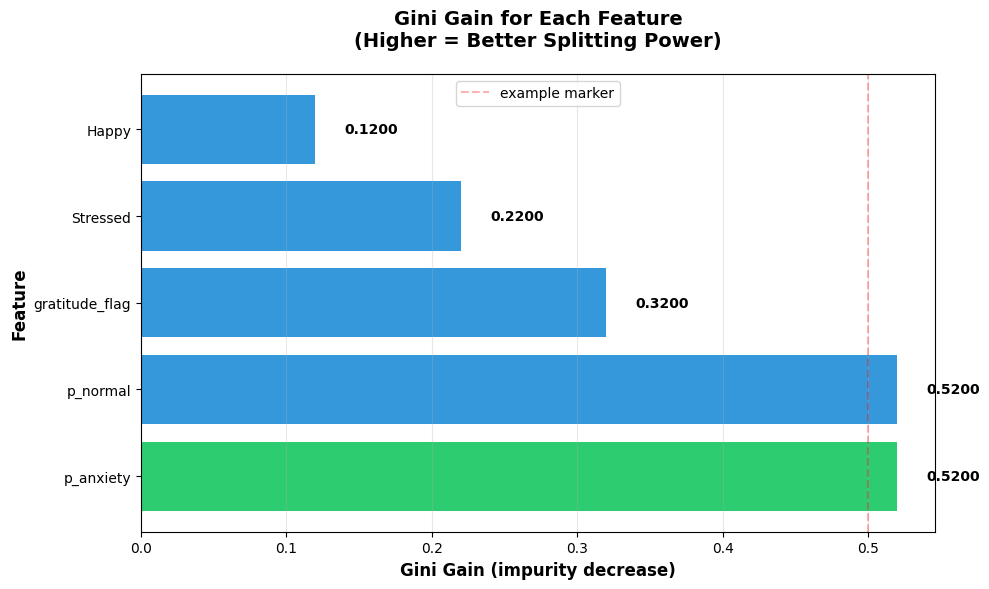

In [23]:
# Visualize Gini Gain
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(gg_df))]
bars = plt.barh(gg_df['Feature'], gg_df['Gini Gain'], color=colors)

# Add value labels
for i, (feature, gain) in enumerate(zip(gg_df['Feature'], gg_df['Gini Gain'])):
    plt.text(gain + 0.02, i, f'{gain:.4f}', va='center', fontsize=10, fontweight='bold')

plt.xlabel('Gini Gain (impurity decrease)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Gini Gain for Each Feature\n(Higher = Better Splitting Power)', 
          fontsize=14, fontweight='bold', pad=20)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.3, label='example marker')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## **Step 3: Build Decision Tree**

Now let's build a decision tree using scikit-learn and visualize it.

In [24]:
# Prepare data for sklearn
X = sample_data[features]
y = sample_data['WellbeingClass']

# Build Decision Tree with gini criterion
dt_classifier = DecisionTreeClassifier(
    criterion='gini',   # Use Gini impurity (now aligned with our manual calculations)
    random_state=42,
    max_depth=3
)

dt_classifier.fit(X, y)

print("✅ Decision Tree trained successfully!")
print(f"\nTree depth: {dt_classifier.get_depth()}")
print(f"Number of leaves: {dt_classifier.get_n_leaves()}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance:")
display(feature_importance)

✅ Decision Tree trained successfully!

Tree depth: 3
Number of leaves: 4

📊 Feature Importance:


,Feature,Importance
0,gratitude_flag,0.4444
2,p_anxiety,0.2778
4,Stressed,0.2778
1,Happy,0.0000
3,p_normal,0.0000


### **Visualize Decision Tree**

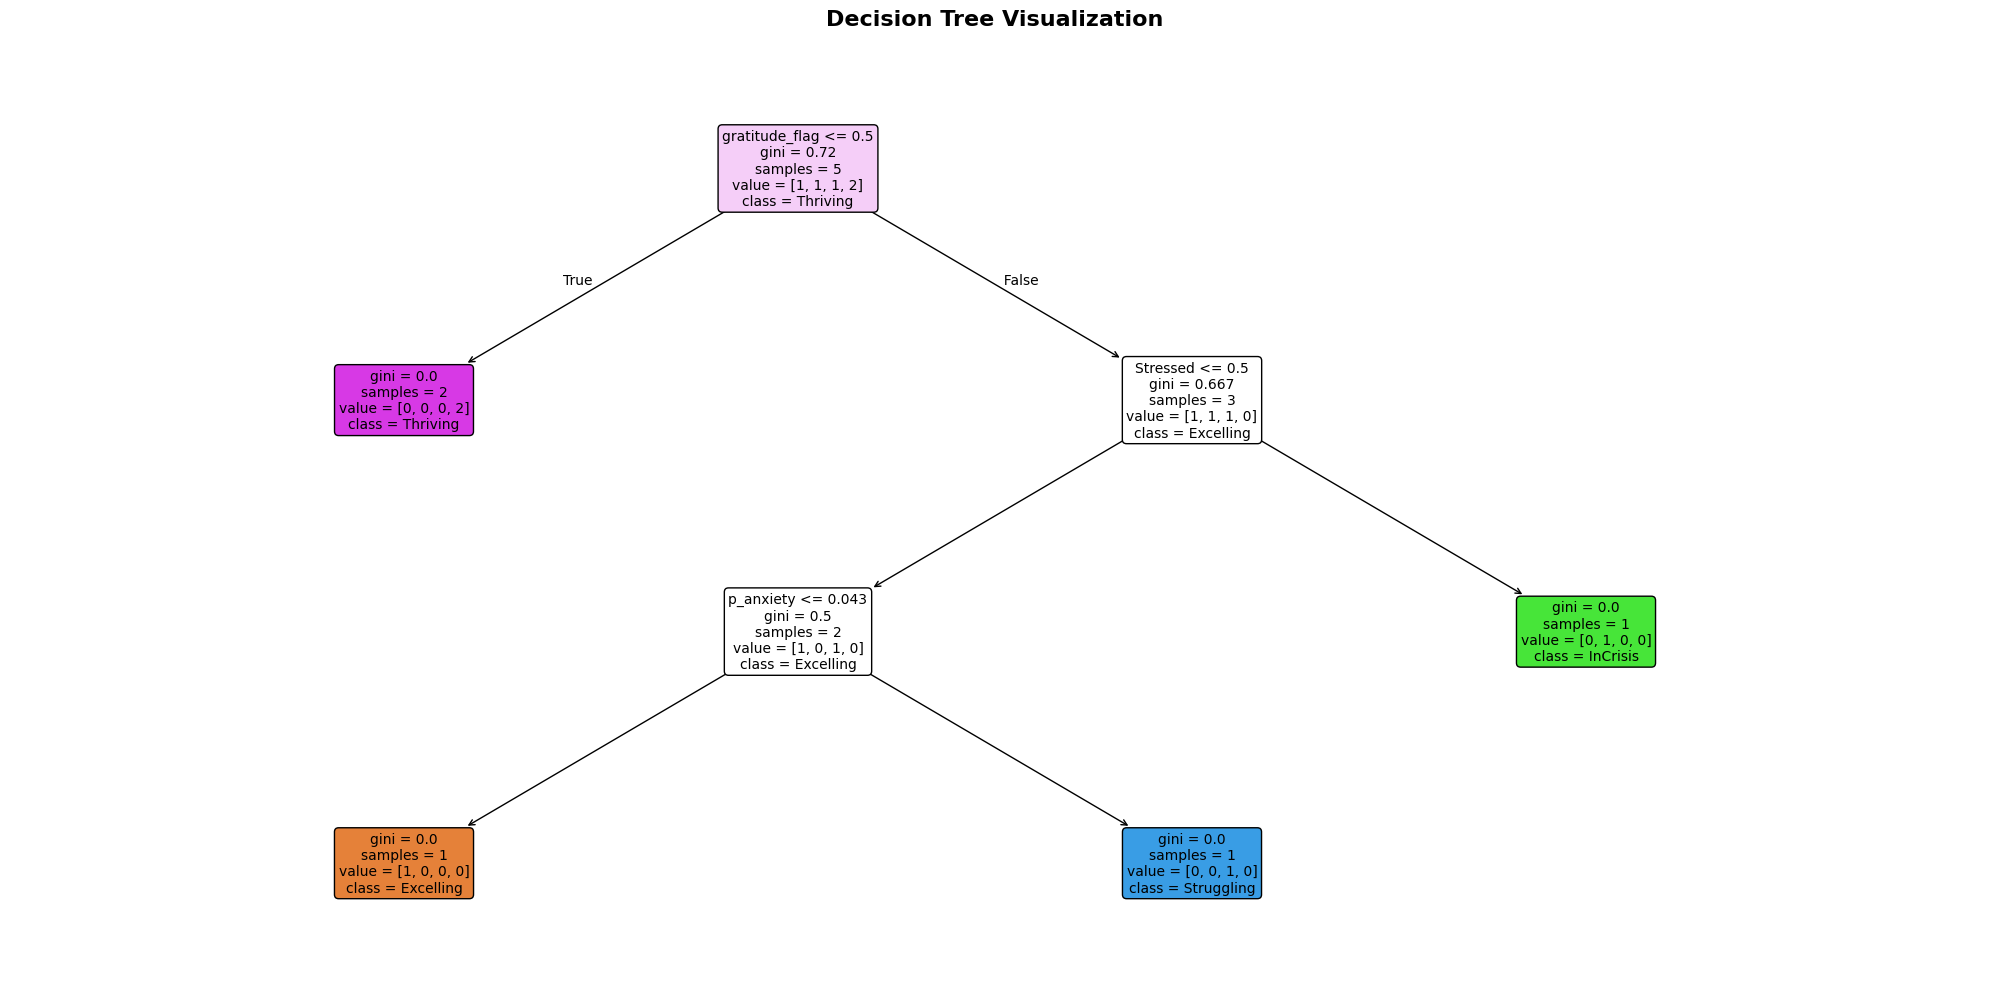

In [25]:
# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=features,
    class_names=dt_classifier.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Visualization', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### **Key Observations:**

1. **Root Node** splits on the feature with highest Information Gain
2. **Leaf Nodes** (colored boxes) represent final predictions
3. **Entropy values** decrease as we go down the tree (increasing purity)
4. **Samples** show how data is distributed at each node

---
# **Part 2: Random Forest** 🌲🌲🌲

## **Theory**

**Random Forest** is an ensemble learning method that builds multiple decision trees and combines their predictions.

### **Key Concepts:**

1. **Bootstrap Aggregating (Bagging):**
   - Create multiple random subsets of training data (with replacement)
   - Train one tree on each subset

2. **Random Feature Selection:**
   - At each split, only consider a random subset of features
   - Default: √(n_features) for classification
   - Increases diversity among trees

3. **Voting:**
   - **Classification:** Majority voting
   - **Regression:** Average predictions

### **Algorithm Flow:**
```
FOR i = 1 to n_estimators:
    1. Create bootstrap sample (random sampling with replacement)
    2. Build decision tree:
       - At each node, randomly select √n features
       - Choose best split from these features only
       - Grow tree fully (no pruning)
    3. Store tree in forest

PREDICTION:
    FOR each tree in forest:
        Get tree's prediction
    RETURN majority class (classification) or mean (regression)
```

### **Advantages over Single Decision Tree:**
- ✅ Reduces overfitting
- ✅ More stable and robust
- ✅ Better generalization
- ✅ Handles high-dimensional data well

## **Manual Simulation: How Random Forest Works**

In [26]:
# Demonstrate bootstrap sampling
def create_bootstrap_sample(data, random_state=None):
    """
    Create a bootstrap sample (random sampling with replacement).
    """
    n = len(data)
    if random_state is not None:
        np.random.seed(random_state)
    
    # Sample with replacement
    indices = np.random.choice(n, size=n, replace=True)
    bootstrap_sample = data.iloc[indices].reset_index(drop=True)
    
    # Out-of-bag samples (not selected)
    oob_indices = list(set(range(n)) - set(indices))
    oob_sample = data.iloc[oob_indices]
    
    return bootstrap_sample, oob_sample, indices

# Create 3 bootstrap samples to show diversity
print("🎲 BOOTSTRAP SAMPLING DEMONSTRATION")
print("=" * 80)
print(f"Original dataset has {len(sample_data)} samples\n")

for i in range(3):
    boot_sample, oob_sample, indices = create_bootstrap_sample(sample_data, random_state=i)
    
    print(f"\n🌳 Tree {i+1} Bootstrap Sample:")
    print(f"   Selected indices: {list(indices)}")
    print(f"   Class distribution: {boot_sample['WellbeingClass'].value_counts().to_dict()}")
    print(f"   Out-of-bag samples: {len(oob_sample)} (used for validation)")
    
print("\n" + "=" * 80)
print("📝 Note: Each tree sees a different random sample of the data!")
print("    This creates diversity among trees, reducing overfitting.")

🎲 BOOTSTRAP SAMPLING DEMONSTRATION
Original dataset has 5 samples


🌳 Tree 1 Bootstrap Sample:
   Selected indices: [np.int32(4), np.int32(0), np.int32(3), np.int32(3), np.int32(3)]
   Class distribution: {'Struggling': 3, 'InCrisis': 1, 'Thriving': 1}
   Out-of-bag samples: 2 (used for validation)

🌳 Tree 2 Bootstrap Sample:
   Selected indices: [np.int32(3), np.int32(4), np.int32(0), np.int32(1), np.int32(3)]
   Class distribution: {'Struggling': 2, 'Thriving': 2, 'InCrisis': 1}
   Out-of-bag samples: 1 (used for validation)

🌳 Tree 3 Bootstrap Sample:
   Selected indices: [np.int32(0), np.int32(0), np.int32(3), np.int32(2), np.int32(3)]
   Class distribution: {'Thriving': 2, 'Struggling': 2, 'Excelling': 1}
   Out-of-bag samples: 2 (used for validation)

📝 Note: Each tree sees a different random sample of the data!
    This creates diversity among trees, reducing overfitting.


## **Feature Randomization at Each Split**

In [27]:
# Demonstrate random feature selection
print("🎯 RANDOM FEATURE SELECTION DEMONSTRATION")
print("=" * 80)

n_features = len(features)
max_features = int(np.sqrt(n_features))  # Default for classification

print(f"Total features available: {n_features}")
print(f"Features considered at each split: {max_features} (√{n_features})")
print(f"\nFeatures: {features}\n")

# Simulate 5 different splits
np.random.seed(42)
for split in range(5):
    selected_features = np.random.choice(features, size=max_features, replace=False)
    print(f"Split {split+1}: Consider features {list(selected_features)}")

print("\n" + "=" * 80)
print("📝 Note: At each node, the tree only considers a random subset!")
print("    This prevents trees from being too similar (decorrelation).")

🎯 RANDOM FEATURE SELECTION DEMONSTRATION
Total features available: 5
Features considered at each split: 2 (√5)

Features: ['gratitude_flag', 'Happy', 'p_anxiety', 'p_normal', 'Stressed']

Split 1: Consider features [np.str_('Happy'), np.str_('Stressed')]
Split 2: Consider features [np.str_('p_normal'), np.str_('Happy')]
Split 3: Consider features [np.str_('Happy'), np.str_('gratitude_flag')]
Split 4: Consider features [np.str_('gratitude_flag'), np.str_('Happy')]
Split 5: Consider features [np.str_('gratitude_flag'), np.str_('p_anxiety')]

📝 Note: At each node, the tree only considers a random subset!
    This prevents trees from being too similar (decorrelation).


## **Build Random Forest and Compare**

In [28]:
# Train Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    criterion='gini',      # Use Gini impurity (consistent with above)
    max_depth=3,
    max_features='sqrt',   # Random feature selection
    bootstrap=True,        # Use bootstrap sampling
    oob_score=True,        # Use out-of-bag samples for validation
    random_state=42,
    n_jobs=-1
)

rf_classifier.fit(X, y)

print("✅ Random Forest trained successfully!")
print(f"\nNumber of trees: {rf_classifier.n_estimators}")
print(f"Out-of-bag score: {rf_classifier.oob_score_:.4f}")

# Feature importance (averaged across all trees)
rf_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance (Random Forest)': rf_classifier.feature_importances_,
    'Importance (Single Tree)': dt_classifier.feature_importances_
}).sort_values('Importance (Random Forest)', ascending=False)

print("\n📊 Feature Importance Comparison:")
display(rf_feature_importance)

✅ Random Forest trained successfully!

Number of trees: 100
Out-of-bag score: 0.0000

📊 Feature Importance Comparison:

📊 Feature Importance Comparison:


,Feature,Importance (Random Forest),Importance (Single Tree)
0,gratitude_flag,0.3062,0.4444
3,p_normal,0.2650,0.0000
2,p_anxiety,0.2388,0.2778
4,Stressed,0.1352,0.2778
1,Happy,0.0548,0.0000


## **Voting Mechanism Visualization**

In [29]:
# Show how individual trees vote
sample_input = X.iloc[0:1]  # Take first sample
true_class = y.iloc[0]

print("🗳️  VOTING DEMONSTRATION")
print("=" * 80)
print("\nInput sample:")
display(sample_input)
print(f"\nTrue class: {true_class}")

# Get predictions from first 10 trees
print("\n📊 Predictions from first 10 trees:")
tree_predictions = []
for i, tree in enumerate(rf_classifier.estimators_[:10]):
    pred = tree.predict(sample_input)[0]
    tree_predictions.append(pred)
    print(f"  Tree {i+1:2d}: {pred}")

# Final prediction (majority vote)
final_prediction = rf_classifier.predict(sample_input)[0]
prediction_proba = rf_classifier.predict_proba(sample_input)[0]

print(f"\n🏆 Final Prediction (Majority Vote): {final_prediction}")
print("\n📊 Class Probabilities:")
for class_name, prob in zip(rf_classifier.classes_, prediction_proba):
    print(f"  {class_name}: {prob:.4f} ({prob*100:.2f}%)")

print("\n" + "=" * 80)

🗳️  VOTING DEMONSTRATION

Input sample:


,gratitude_flag,Happy,p_anxiety,p_normal,Stressed
0,0,0,0.139,0.546,0



True class: Thriving

📊 Predictions from first 10 trees:
  Tree  1: 2.0
  Tree  2: 2.0
  Tree  3: 3.0
  Tree  4: 3.0
  Tree  5: 3.0
  Tree  6: 3.0
  Tree  7: 2.0
  Tree  8: 3.0
  Tree  9: 3.0
  Tree 10: 3.0

🏆 Final Prediction (Majority Vote): Thriving

📊 Class Probabilities:
  Excelling: 0.0000 (0.00%)
  InCrisis: 0.0500 (5.00%)
  Struggling: 0.1800 (18.00%)
  Thriving: 0.7700 (77.00%)



### **Comparison: Single Tree vs Random Forest**

In [30]:
# Compare predictions
comparison_df = pd.DataFrame({
    'Sample': range(len(y)),
    'True Class': y.values,
    'Decision Tree': dt_classifier.predict(X),
    'Random Forest': rf_classifier.predict(X)
})

comparison_df['DT Correct'] = comparison_df['True Class'] == comparison_df['Decision Tree']
comparison_df['RF Correct'] = comparison_df['True Class'] == comparison_df['Random Forest']

print("🔍 PREDICTION COMPARISON")
print("=" * 80)
display(comparison_df)

print(f"\n✅ Decision Tree Accuracy: {comparison_df['DT Correct'].mean():.2%}")
print(f"✅ Random Forest Accuracy: {comparison_df['RF Correct'].mean():.2%}")

🔍 PREDICTION COMPARISON


,Sample,True Class,Decision Tree,Random Forest,DT Correct,RF Correct
0,0,Thriving,Thriving,Thriving,True,True
1,1,Thriving,Thriving,Thriving,True,True
2,2,Excelling,Excelling,Excelling,True,True
3,3,Struggling,Struggling,Struggling,True,True
4,4,InCrisis,InCrisis,InCrisis,True,True



✅ Decision Tree Accuracy: 100.00%
✅ Random Forest Accuracy: 100.00%


---
# **Part 3: XGBoost (Extreme Gradient Boosting)** 🚀

## **Theory**

**XGBoost** is a gradient boosting algorithm that builds trees sequentially, where each new tree corrects errors made by previous trees.

### **Key Differences from Random Forest:**

| Aspect | Random Forest | XGBoost |
|--------|--------------|----------|
| **Training** | Parallel (independent trees) | Sequential (trees correct errors) |
| **Trees** | Full depth trees | Shallow trees (typically) |
| **Goal** | Reduce variance (bagging) | Reduce bias (boosting) |
| **Weighting** | Equal weight for all trees | Weighted by performance |
| **Speed** | Fast (parallel) | Can be slower (sequential) |

### **Algorithm Flow:**
```
1. Initialize: F₀(x) = initial prediction (e.g., mean)

2. FOR m = 1 to M (number of trees):
   a. Compute residuals (errors from current model):
      r_i = y_i - F_{m-1}(x_i)
   
   b. Fit new tree h_m to residuals:
      h_m = DecisionTree(X, residuals)
   
   c. Update model with learning rate η:
      F_m(x) = F_{m-1}(x) + η * h_m(x)
   
   d. Apply regularization (L1, L2)

3. RETURN: F_M(x) = sum of all trees
```

### **Mathematical Foundation:**

**Objective Function:**
$$
\text{Obj} = \sum_{i=1}^{n} L(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

Where:
- $L$ = Loss function (e.g., cross-entropy for classification)
- $\Omega$ = Regularization term (controls tree complexity)
- $K$ = Number of trees

**Regularization:**
$$
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2
$$

Where:
- $T$ = Number of leaves
- $w_j$ = Leaf weights
- $\gamma$ = Complexity penalty for leaves
- $\lambda$ = L2 regularization

## **Manual Simulation: Gradient Boosting Concept**

In [31]:
# Simplified demonstration of boosting concept
print("🎯 GRADIENT BOOSTING CONCEPT DEMONSTRATION")
print("=" * 80)
print("\nSimplified example with regression on a single value:\n")

# Target value
true_value = 100
learning_rate = 0.3

print(f"True value: {true_value}")
print(f"Learning rate: {learning_rate}\n")

# Initialize with mean
predictions = []
residuals = []

# Initial prediction (simple mean)
current_pred = 50  # Start with a guess
predictions.append(current_pred)

print(f"{'Tree':<8} {'Prediction':<15} {'Residual':<15} {'New Pred':<15}")
print("-" * 60)
print(f"{'Init':<8} {current_pred:<15.2f} {true_value - current_pred:<15.2f} {current_pred:<15.2f}")

# Simulate 5 boosting iterations
for tree_num in range(1, 6):
    # Calculate residual (error)
    residual = true_value - current_pred
    residuals.append(residual)
    
    # New tree predicts the residual (simplified: just use the residual)
    tree_prediction = residual
    
    # Update prediction with learning rate
    current_pred = current_pred + learning_rate * tree_prediction
    predictions.append(current_pred)
    
    print(f"{'Tree ' + str(tree_num):<8} {tree_prediction:<15.2f} {residual:<15.2f} {current_pred:<15.2f}")

print("\n" + "=" * 80)
print(f"\n📊 Final prediction after 5 trees: {current_pred:.2f}")
print(f"📊 Remaining error: {abs(true_value - current_pred):.2f}")
print("\n💡 Key Insight: Each tree focuses on correcting the errors of previous trees!")

🎯 GRADIENT BOOSTING CONCEPT DEMONSTRATION

Simplified example with regression on a single value:

True value: 100
Learning rate: 0.3

Tree     Prediction      Residual        New Pred       
------------------------------------------------------------
Init     50.00           50.00           50.00          
Tree 1   50.00           50.00           65.00          
Tree 2   35.00           35.00           75.50          
Tree 3   24.50           24.50           82.85          
Tree 4   17.15           17.15           87.99          
Tree 5   12.01           12.01           91.60          


📊 Final prediction after 5 trees: 91.60
📊 Remaining error: 8.40

💡 Key Insight: Each tree focuses on correcting the errors of previous trees!


## **XGBoost Implementation**

Note: XGBoost requires separate installation: `pip install xgboost`

In [32]:
# Check if XGBoost is installed
try:
    import xgboost as xgb
    from sklearn.preprocessing import LabelEncoder
    
    # Encode labels for XGBoost
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Train XGBoost
    xgb_classifier = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.3,
        objective='multi:softmax',
        num_class=len(np.unique(y_encoded)),
        random_state=42
    )
    
    xgb_classifier.fit(X, y_encoded)
    
    print("✅ XGBoost trained successfully!")
    print(f"\nNumber of boosting rounds: {xgb_classifier.n_estimators}")
    print(f"Learning rate: {xgb_classifier.learning_rate}")
    
    # Feature importance
    xgb_feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': xgb_classifier.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n📊 XGBoost Feature Importance:")
    display(xgb_feature_importance)
    
    xgboost_available = True
    
except ImportError:
    print("⚠️  XGBoost not installed. Install with: pip install xgboost")
    xgboost_available = False

✅ XGBoost trained successfully!

Number of boosting rounds: 100
Learning rate: 0.3

📊 XGBoost Feature Importance:


,Feature,Importance
0,gratitude_flag,0.0
1,Happy,0.0
2,p_anxiety,0.0
3,p_normal,0.0
4,Stressed,0.0


---
# **Final Comparison: All Three Algorithms** 🏆

In [33]:
# Compare all three models
print("📊 COMPREHENSIVE COMPARISON")
print("=" * 80)

comparison_data = {
    'Algorithm': ['Decision Tree', 'Random Forest'],
    'Training Time': ['Fast', 'Moderate'],
    'Prediction Time': ['Very Fast', 'Fast'],
    'Overfitting Risk': ['High', 'Low'],
    'Interpretability': ['High', 'Low'],
    'Accuracy (Sample)': [
        f"{(dt_classifier.predict(X) == y).mean():.2%}",
        f"{(rf_classifier.predict(X) == y).mean():.2%}"
    ]
}

if xgboost_available:
    xgb_predictions = le.inverse_transform(xgb_classifier.predict(X))
    comparison_data['Algorithm'].append('XGBoost')
    comparison_data['Training Time'].append('Slow')
    comparison_data['Prediction Time'].append('Fast')
    comparison_data['Overfitting Risk'].append('Low')
    comparison_data['Interpretability'].append('Low')
    comparison_data['Accuracy (Sample)'].append(f"{(xgb_predictions == y.values).mean():.2%}")

comparison_table = pd.DataFrame(comparison_data)
display(comparison_table)

📊 COMPREHENSIVE COMPARISON


,Algorithm,Training Time,Prediction Time,Overfitting Risk,Interpretability,Accuracy (Sample)
0,Decision Tree,Fast,Very Fast,High,High,100.00%
1,Random Forest,Moderate,Fast,Low,Low,100.00%
2,XGBoost,Slow,Fast,Low,Low,40.00%


## **Feature Importance Comparison (All Models)**

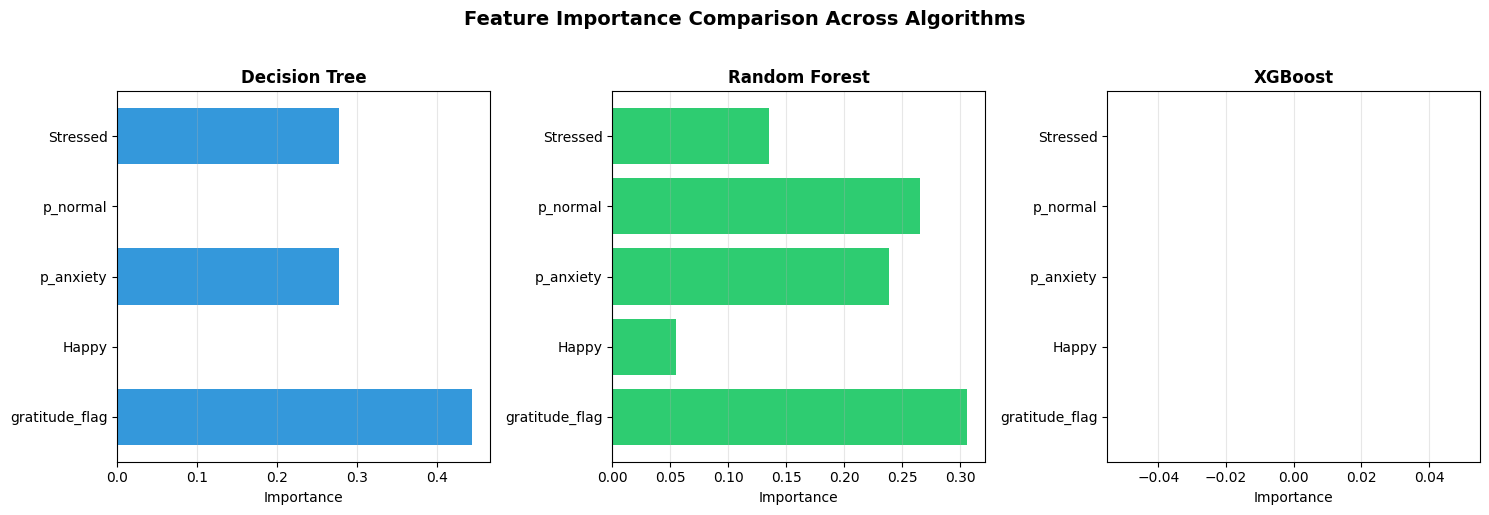

In [34]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 3 if xgboost_available else 2, figsize=(15, 5))

# Decision Tree
axes[0].barh(features, dt_classifier.feature_importances_, color='#3498db')
axes[0].set_xlabel('Importance')
axes[0].set_title('Decision Tree', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Random Forest
axes[1].barh(features, rf_classifier.feature_importances_, color='#2ecc71')
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# XGBoost
if xgboost_available:
    axes[2].barh(features, xgb_classifier.feature_importances_, color='#e74c3c')
    axes[2].set_xlabel('Importance')
    axes[2].set_title('XGBoost', fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Comparison Across Algorithms', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
# **Summary & Key Takeaways** 📚

## **1. Decision Trees**
### When to Use:
- ✅ Need interpretability
- ✅ Quick prototyping
- ✅ Small datasets
- ✅ Feature interactions important

### Limitations:
- ❌ Prone to overfitting
- ❌ Unstable (small data changes = big tree changes)
- ❌ Biased toward dominant classes

---

## **2. Random Forest**
### When to Use:
- ✅ Need robust predictions
- ✅ Large datasets
- ✅ High-dimensional data
- ✅ Want feature importance
- ✅ Don't need interpretability

### Advantages:
- ✅ Reduces overfitting
- ✅ Handles missing values well
- ✅ Works out-of-the-box (less tuning)
- ✅ Provides confidence (probability estimates)

---

## **3. XGBoost**
### When to Use:
- ✅ Need best performance
- ✅ Kaggle competitions
- ✅ Have time for hyperparameter tuning
- ✅ Large datasets
- ✅ Imbalanced classes

### Advantages:
- ✅ Often highest accuracy
- ✅ Built-in regularization
- ✅ Handles missing values
- ✅ Fast (optimized C++ implementation)
- ✅ Feature importance

### Disadvantages:
- ❌ More hyperparameters to tune
- ❌ Less interpretable
- ❌ Can overfit if not careful

---

## **Quick Selection Guide**

```
Need interpretability?  → Decision Tree
Need good performance with minimal tuning?  → Random Forest
Need best possible performance?  → XGBoost
Have lots of data?  → Random Forest or XGBoost
Have little data?  → Decision Tree (with pruning)
Need fast predictions?  → Decision Tree
```

---

## **Mathematical Summary**

### Entropy:
$$H(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$$

### Information Gain:
$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

### Random Forest Prediction:
$$\hat{y} = \text{mode}\{h_1(x), h_2(x), ..., h_T(x)\}$$

### XGBoost Objective:
$$\text{Obj} = \sum_{i=1}^{n} L(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$$

---
## **References & Further Reading**

1. **Decision Trees:**
   - Breiman et al. (1984). Classification and Regression Trees (CART)
   - Quinlan (1986). Induction of Decision Trees

2. **Random Forests:**
   - Breiman (2001). Random Forests
   - [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/ensemble.html#forest)

3. **XGBoost:**
   - Chen & Guestrin (2016). XGBoost: A Scalable Tree Boosting System
   - [XGBoost Documentation](https://xgboost.readthedocs.io/)

4. **Code References:**
   - `sklearn.tree._classes.py` - Decision Tree implementation
   - `sklearn.tree._tree.pyx` - Core tree building (Cython)
   - `sklearn.tree._criterion.pyx` - Entropy & Gini calculations
   - `sklearn.ensemble._forest.py` - Random Forest implementation